# Document Classification 
There are a set of documents under two different categories. We perform supervised
learning to classify each document into the corret category. 

In [15]:
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn import metrics
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from pprint import pprint
import numpy as np
import re
import os
from time import time
import matplotlib.pyplot as plt
import pickle

folder_path = "data/articles_classified"
assert os.path.exists(folder_path), "The folder is not found"

try:
    print("Loading all documents from the folder into the memory")
    documents = load_files(folder_path, shuffle=True, encoding='utf-8')
except FileNotFoundError:
    print("Cannot load the files at '%s'" % folder_path)
else:
    print("In total %d documents loaded" % len(documents.data))     
    
for i, e in enumerate(documents.target_names):
    print("%d documents in %s categories" % 
          (len(documents.target[documents.target == i]), e))

Loading all documents from the folder into the memory
In total 42 documents loaded
21 documents in business categories
21 documents in sports categories


## Preprecossing text data 
We preprocess the raw text and further extract, vectorize
and normalize features for classification task.

In [2]:
for i in range(len(documents.data)):
    # Normalize words into lowercase
    documents.data[i] = documents.data[i].lower()

    # Remove punctuations, linebreaks, numbers and short words
    symbols = ['[-./?!,":;()|$\'\”]', 
                '[\r?\n]+', '[0-9]+', 
                r'\b[a-zA-Z]{1,3}\b']
    for symbol in symbols :
        documents.data[i] = re.sub(symbol, ' ', documents.data[i])

In [3]:
# Split the data into a training set and a test set 
X_train, X_test, y_train, y_test = train_test_split(
    documents.data, documents.target, train_size = 0.8, random_state=None)

We tokenize the documents into words, and then extract two types of features as
bag-of-words (BoW) model.
1: CountVectorizer collects token's occurence counts
2: TfidfVectorizer collects token's term-frequency and inverted document-frequency
We use the default ngram_range=(1,1), and can set (1,2) to account for bigrams.
However, given our limited sample size and already large feature dimensions, bigrams
or n-grams can be useful for classification tasks that also account for the order of
words for larger text corpus.

In [4]:
# Tokenizating text and filtering stopwords, rare words and common words
# CountVectorizer collects token's occurence counts
vectorizer = CountVectorizer(lowercase=True, stop_words='english',
                             min_df=2, max_df=0.9)

X = vectorizer.fit_transform(documents.data)
print("Number of sample: %d, number of features: %d" % X.shape)

# TfidfVectorizer collects TF-IDF measures
vectorizer_tfidf = TfidfVectorizer(lowercase=True, stop_words='english',
                                  min_df=2, max_df=0.9)
X_tfidf = vectorizer_tfidf.fit_transform(documents.data)

Number of sample: 42, number of features: 1646


## Classifying news articles
Our task is a typical binary classification with balanced samples in two classes.
We use the following classifiers that were commonly used in similar settings to 
perform the task:
1. Logistic Regression
2. Naive Bayes (Multinomial, Bernoulli)
4. Linear SVM  
5. Random Forest

We fit the training set with each classifier. To reduce overfitting, we introduce 
regularization terms to penalize the loss function. We use exhaustive grid search 
to choose hyperparameters for each classifier that has the best cross validation 
score.

In [5]:
# Logistic Regression Classifer
pipeline_lr = Pipeline([
        ('vect', vectorizer),
        ('clf', LogisticRegression(multi_class='ovr'))
    ])

start = time()

# Set the dictionairy of hyperparameters
parameters_logit = {
    'clf__C': [1e-3, 1e-2, 1e-1, 1.0, 10.0],
    'clf__penalty': ['l1', 'l2']
    }
        
# Perform grid search over parameter space and obtain the best estimator
clf_grid_logit = GridSearchCV(pipeline_lr, 
                              parameters_logit, 
                              n_jobs=-1).fit(X_train, y_train)
clf_logit = clf_grid_logit.best_estimator_
print("The best estimator obtained is: ")
print(clf_logit._final_estimator)
print("The best params obtained are: %s" % clf_grid_logit.best_params_)

# Predict the outcome on the test set
y_predicted = clf_logit.predict(X_test)

# Print the training and testing time
print("Time used for training and testing: %0.2fs" % (time() - start))

# Print the classification report
print("Classification report:")
print(metrics.classification_report(y_test, y_predicted, target_names=documents.target_names))
# Print and plot the confusion matrix
print("Confusion matrix:")
cm = metrics.confusion_matrix(y_test, y_predicted)
print(cm)

#Print the accuracy on left-out test set  
print("Test accuracy: %0.2f" % clf_logit.fit(X_train, y_train).score(X_test, y_test)) 
scores = cross_val_score(clf_logit, X_train, y_train, cv=10)
print("Cross-validation accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

The best estimator obtained is: 
LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
The best params obtained are: {'clf__C': 0.001, 'clf__penalty': 'l2'}
Time used for training and testing: 1.44s
Classification report:
             precision    recall  f1-score   support

   business       1.00      1.00      1.00         4
     sports       1.00      1.00      1.00         5

avg / total       1.00      1.00      1.00         9

Confusion matrix:
[[4 0]
 [0 5]]
Test accuracy: 1.00
Cross-validation accuracy: 0.95 (+/- 0.10)


We can fit other classifiers in a similar fashion. Specifically, we can build
a ''pipeline'' for each classifier to allow for chaining multiple transformation
and estimations.

In [6]:
# Multinomial Naive Bayes as classifier
pipeline_multinomial_bayes = Pipeline([
        ('vect', vectorizer),
        ('clf', MultinomialNB())
    ])

start = time()

# Set the dictionairy of hyperparameters for additive smoothing
parameters_bayes = {
    'clf__alpha': [1e-3, 1e-2, 1e-1, 1.0]
    }

# Perform grid search over parameter space and obtain the best estimator
multinomial_bayes_grid = GridSearchCV(pipeline_multinomial_bayes, 
                              parameters_bayes, 
                              n_jobs=-1).fit(X_train, y_train)
multinomial_bayes_clf = multinomial_bayes_grid.best_estimator_
print("The best estimator obtained for Multinomial Naive Bayes is: ")
print(multinomial_bayes_clf._final_estimator)
print("The best params obtained is: %s" % multinomial_bayes_grid.best_params_)

# Predict the outcome on the test set
y_predicted = multinomial_bayes_clf.predict(X_test)

# Print the training and testing time
print("Time used for training and testing: %0.2fs" % (time() - start))

# Print the classification report
print("Classification report:")
print(metrics.classification_report(y_test, y_predicted, target_names=documents.target_names))
# Print and plot the confusion matrix
print("Confusion matrix:")
cm = metrics.confusion_matrix(y_test, y_predicted)
print(cm)

#Print the accuracy on left-out test set and cross-validation
print("Test accuracy: %0.2f" % multinomial_bayes_clf.fit(X_train, y_train).score(X_test, y_test)) 
scores = cross_val_score(multinomial_bayes_clf, X_train, y_train, cv=10)
print("Cross-validation accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

The best estimator obtained for Multinomial Naive Bayes is: 
MultinomialNB(alpha=0.001, class_prior=None, fit_prior=True)
The best params obtained is: {'clf__alpha': 0.001}
Time used for training and testing: 0.83s
Classification report:
             precision    recall  f1-score   support

   business       1.00      1.00      1.00         4
     sports       1.00      1.00      1.00         5

avg / total       1.00      1.00      1.00         9

Confusion matrix:
[[4 0]
 [0 5]]
Test accuracy: 1.00
Cross-validation accuracy: 0.97 (+/- 0.07)


In [7]:
# Bernoulli Naive Bayes as classifier
pipeline_bernoulli_bayes = Pipeline([
        ('vect', vectorizer),
        ('clf', BernoulliNB())
    ])

start = time()

# Set the dictionairy of hyperparameters for additive smoothing
parameters_bayes = {
    'clf__alpha': [1e-3, 1e-2, 1e-1, 1.0]
    }

# Perform grid search over parameter space and obtain the best estimator
bernoullie_bayes_grid = GridSearchCV(pipeline_bernoulli_bayes, 
                              parameters_bayes, 
                              n_jobs=-1).fit(X_train, y_train)
bernoulli_bayes_clf = bernoullie_bayes_grid.best_estimator_
print("The best estimator obtained for Bernoulli Naive Bayes is: ")
print(bernoulli_bayes_clf._final_estimator)
print("The best params obtained is: %s" % bernoullie_bayes_grid.best_params_)

# Predict the outcome on the test set
y_predicted = bernoulli_bayes_clf.predict(X_test)

# Print the training and testing time
print("Time used for training and testing: %0.2fs" % (time() - start))

# Print the classification report
print("Classification report:")
print(metrics.classification_report(y_test, y_predicted, target_names=documents.target_names))
# Print and plot the confusion matrix
print("Confusion matrix:")
cm = metrics.confusion_matrix(y_test, y_predicted)
print(cm)

#Print the accuracy on left-out test set and cross-validation
print("Test accuracy: %0.2f" % bernoulli_bayes_clf.fit(X_train, y_train).score(X_test, y_test)) 
scores = cross_val_score(bernoulli_bayes_clf, X_train, y_train, cv=10)
print("Cross-validation accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

The best estimator obtained for Bernoulli Naive Bayes is: 
BernoulliNB(alpha=0.01, binarize=0.0, class_prior=None, fit_prior=True)
The best params obtained is: {'clf__alpha': 0.01}
Time used for training and testing: 0.70s
Classification report:
             precision    recall  f1-score   support

   business       1.00      1.00      1.00         4
     sports       1.00      1.00      1.00         5

avg / total       1.00      1.00      1.00         9

Confusion matrix:
[[4 0]
 [0 5]]
Test accuracy: 1.00
Cross-validation accuracy: 1.00 (+/- 0.00)


In [8]:
# Linear SVM as classifier
pipeline_svm = Pipeline([
        ('vect', vectorizer),
        ('clf', LinearSVC(multi_class='ovr'))
    ])

start = time()

# Set the dictionairy of hyperparameters for C
parameters_svm = {
    'clf__C': [1e-3, 1e-2, 1e-1, 1.0, 10.0]
    }

# Perform grid search over parameter space and obtain the best estimator
svm_grid = GridSearchCV(pipeline_svm, 
                              parameters_svm, 
                              n_jobs=-1).fit(X_train, y_train)
svm_clf = svm_grid.best_estimator_
print("The best estimator obtained for Linear SVM is: ")
print(svm_clf._final_estimator)
print("The best params obtained is: %s" % svm_grid.best_params_)

# Predict the outcome on the test set
y_predicted = svm_clf.predict(X_test)

# Print the training and testing time
print("Time used for training and testing: %0.2fs" % (time() - start))

# Print the classification report
print("Classification report:")
print(metrics.classification_report(y_test, y_predicted, target_names=documents.target_names))
# Print and plot the confusion matrix
print("Confusion matrix:")
cm = metrics.confusion_matrix(y_test, y_predicted)
print(cm)

#Print the accuracy on left-out test set and cross-validation
print("Test accuracy: %0.2f" % svm_clf.fit(X_train, y_train).score(X_test, y_test)) 
scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
print("Cross-validation accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

The best estimator obtained for Linear SVM is: 
LinearSVC(C=0.001, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
The best params obtained is: {'clf__C': 0.001}
Time used for training and testing: 0.68s
Classification report:
             precision    recall  f1-score   support

   business       1.00      1.00      1.00         4
     sports       1.00      1.00      1.00         5

avg / total       1.00      1.00      1.00         9

Confusion matrix:
[[4 0]
 [0 5]]
Test accuracy: 1.00
Cross-validation accuracy: 0.97 (+/- 0.07)


In [9]:
# Random Forests as classifier, note that Random Forest may take long 
# training time that depends on the number and depth of trees 
pipeline_rf = Pipeline([
        ('vect', vectorizer),
        ('clf', RandomForestClassifier())
    ])

start = time()

# Set the dictionairy of hyperparameters for 
parameters_rf = {
    'clf__max_features': ['sqrt', 'log2', None],
    'clf__n_estimators': [30, 50, 100, 150],
    'clf__min_samples_leaf': [1, 2, 5, 10]
    }

# Perform grid search over parameter space and obtain the best estimator
rf_grid = GridSearchCV(pipeline_rf, 
                              parameters_rf, 
                              n_jobs=-1).fit(X_train, y_train)
rf_clf = rf_grid.best_estimator_
print("The best estimator obtained for Random Forests is: ")
print(rf_clf._final_estimator)
print("The best params obtained is: %s" % rf_grid.best_params_)

# Predict the outcome on the test set
y_predicted = rf_clf.predict(X_test)

# Print the training and testing time
print("Time used for training and testing: %0.2fs" % (time() - start))

# Print the classification report
print("Classification report:")
print(metrics.classification_report(y_test, y_predicted, target_names=documents.target_names))
# Print and plot the confusion matrix
print("Confusion matrix:")
cm = metrics.confusion_matrix(y_test, y_predicted)
print(cm)

#Print the accuracy on left-out test set and cross-validation
print("Test accuracy: %0.2f" % rf_clf.fit(X_train, y_train).score(X_test, y_test)) 
scores = cross_val_score(rf_clf, X_train, y_train, cv=10)
print("Cross-validation accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

The best estimator obtained for Random Forests is: 
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='log2', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=150, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
The best params obtained is: {'clf__min_samples_leaf': 1, 'clf__max_features': 'log2', 'clf__n_estimators': 150}
Time used for training and testing: 17.64s
Classification report:
             precision    recall  f1-score   support

   business       1.00      0.75      0.86         4
     sports       0.83      1.00      0.91         5

avg / total       0.91      0.89      0.89         9

Confusion matrix:
[[3 1]
 [0 5]]
Test accuracy: 0.89
Cross-validation accuracy: 0.97 (+/- 0.07)


We can further combine the above classifiers to make a better prediction, 
e.g., through majority voting mechanism. This is particularly useful when 
classifiers are performing equally well and voting classifier can balance 
out their individual weaknesses.

We see that linear classifiers generally performs well, as data can be more
easily separated linearly in high-dimensional spaces. However, we caution 
the interpretation of this result to be siginificant given the very limited
sample size.

In [10]:
voting_clf = VotingClassifier(estimators=[('lr', clf_logit), ('mnnb', multinomial_bayes_clf),
                                         ('bnnb', bernoulli_bayes_clf), ('lsvm', svm_clf),
                                         ('rf', rf_clf)], voting='hard')

for clf, label in zip([clf_logit, multinomial_bayes_clf, bernoulli_bayes_clf, svm_clf, 
                       rf_clf, voting_clf],
                     ['Logistic Regression', 'Multinomial Naive Bayes', 'Bernoulli Naive Bayes',
                     'Linear SVM', 'Random Forests', 'Voting']):
    scores = cross_val_score(clf, X_train, y_train, cv=10)
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.95 (+/- 0.10) [Logistic Regression]
Accuracy: 0.97 (+/- 0.07) [Multinomial Naive Bayes]
Accuracy: 1.00 (+/- 0.00) [Bernoulli Naive Bayes]
Accuracy: 0.97 (+/- 0.07) [Linear SVM]
Accuracy: 0.94 (+/- 0.12) [Random Forests]
Accuracy: 1.00 (+/- 0.00) [Voting]


## Wrapper function
We can write parameterized wrapper functions for pipelines that
are easy to be called, using different feature extractors, classifers,
and results reports

In [11]:
# Parameterized training model
def training(vect, clf, params, X_train, y_train):
    print('_' * 80)
    print("Start training %s: " % clf.__class__.__name__)
    
    # Set up the pipeline
    pipeline = Pipeline([
        ('vect', vect),
        ('clf', clf)       
    ])
    
    start = time()
    
    # Set the dictionairy of hyperparameters 
    params = params
    
    # Perform grid search over parameter space and obtain the best estimator
    grid_search = GridSearchCV(pipeline, params, n_jobs=-1).fit(X_train, y_train)
    grid_clf = grid_search.best_estimator_
    print("The best estimator obtained is: ")
    pprint(grid_clf._final_estimator)
    print("The best params obtained is: %s" % grid_search.best_params_)
    print("Time used for training: %0.2fs" % (time() - start))
    return grid_clf

# Present evaluation results 
def evaluation(grid_clf, X_test, y_test):
    print("Predict the outcome on the test set")
    y_predicted = grid_clf.predict(X_test)

    # Print the classification report
    print("Classification report:")
    print(metrics.classification_report(y_test, y_predicted, target_names=documents.target_names))
    # Print and plot the confusion matrix
    print("Confusion matrix:")
    cm = metrics.confusion_matrix(y_test, y_predicted)
    print(cm)

    #Print the accuracy on left-out test set and cross-validation
    print("Test accuracy: %0.2f" % metrics.accuracy_score(y_test, y_predicted)) 
    scores = cross_val_score(grid_clf, X_train, y_train, cv=10)
    print("Cross-validation accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))
    return scores

Then we simply call training function to train classification model with 
specified parameters and save the model and calculate the cross-validation 
accuracy score

In [12]:
trained_models = []
results = []
vect_list = [vectorizer, vectorizer, vectorizer_tfidf, vectorizer_tfidf, vectorizer]
clf_list = [LogisticRegression(multi_class='ovr'),
           MultinomialNB(), BernoulliNB(),
           LinearSVC(multi_class='ovr'),
           RandomForestClassifier()]
params_list = [parameters_logit, parameters_bayes, parameters_bayes,
              parameters_svm, parameters_rf]

for i, (l1, l2, l3)  in enumerate(zip(vect_list, clf_list, params_list)):
    #print(i, l1, l2, l3)
    trained_models.append(training(l1, l2, l3, X_train, y_train))
    results.append(evaluation(trained_models[i], X_test, y_test))

________________________________________________________________________________
Start training LogisticRegression: 
The best estimator obtained is: 
LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
The best params obtained is: {'clf__C': 0.001, 'clf__penalty': 'l2'}
Time used for training: 1.11s
Predict the outcome on the test set
Classification report:
             precision    recall  f1-score   support

   business       1.00      1.00      1.00         4
     sports       1.00      1.00      1.00         5

avg / total       1.00      1.00      1.00         9

Confusion matrix:
[[4 0]
 [0 5]]
Test accuracy: 1.00
Cross-validation accuracy: 0.95 (+/- 0.10)
________________________________________________________________________________
Start training MultinomialNB: 
Th

Besides precision-recall and confusion matrix, we can also visualize
the calssifier output quality, e.g, through Receive Operating 
Characteristic (ROC) curve and area under the curve (AUC). Below
shows an example of Logistic Regression, where we obtain the perfect
prediction, i.e., AUC = 1 for 100% of test accuracy

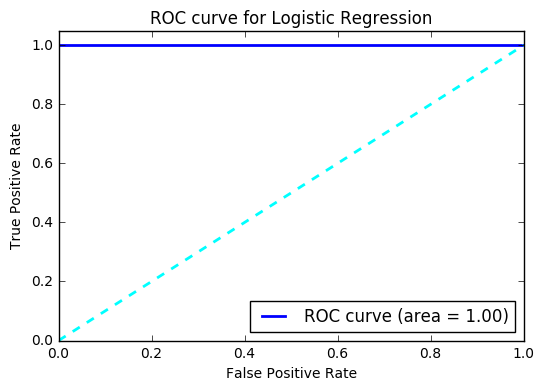

In [13]:
y_predicted = clf_logit.fit(X_train, y_train).predict(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_predicted)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, color='blue',
        label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='cyan', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for Logistic Regression')
plt.legend(loc="lower right")
plt.show()

Finally, we train our model using the whole dataset and persist the model 
for future use without have to retrain. 

In [14]:
clf_dump = []
for trained_model in trained_models:    
    clf_dump.append(pickle.dumps(trained_model.fit(documents.data, documents.target)))

# Load a trained model for ready use    
clf2 = pickle.loads(clf_dump[1])
print("Trained ad hoc model: %s" % clf2._final_estimator)
print("Test accuracy from ad hoc model is %0.2f:" %  metrics.accuracy_score(y_test, clf2.predict(X_test)))

Trained ad hoc model: MultinomialNB(alpha=0.001, class_prior=None, fit_prior=True)
Test accuracy from ad hoc model is 1.00:
